In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

# Example Implementation

Here we provide a minimal working example demonstrating how to use the code to estimate the amplitude using the ESPIRIT algorithm.

In [12]:
# For reproducibility
# np.random.seed(7)
# Set the per oracle noise parameter (See Eq. 18)
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*12
# Set the actual angle
a=0.3
theta = np.arcsin(a)

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=5)
# Number of Monte Carlo trials used to estimate statistics. We tend to use 500 in the paper. Choose 100 here for speed.
num_mc = 100
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()
music = MUSIC()


for k in range(num_mc):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using the ESPIRIT algorithm
    theta_est, angle = espirit.estimate_theta_toeplitz(R)
    # R = ula_signal.get_cov_matrix(signal)
    # theta_est = music.estimate_theta(R, lanczos = False)
    # print(angle)
    # Estimate the error between estimated a and actual a
    error = np.abs(np.sin(theta)-np.sin(theta_est)) 
    thetas[k] = theta_est            
    errors[k] = error

# Compute the total number of queries. The additional count of ula_signal.n_samples[0] is to 
# account for the fact that the Grover oracle has two invocations of the unitary U, but is 
# preceded by a single invocation of U (see Eq. 2 in paper). This accounts for the shots required
# for that single U operator, which costs half as much as the Grover oracle.
num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Array parameters: {narray}')
print(f'Number of queries: {num_queries}')
print(f'theta: {theta}')
print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas))}')
print(f'Max Single Query: {max_single_query}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print()


TypeError: Lanczost expected 3 arguments, got 1

In [3]:
# For reproducibility
# np.random.seed(7)
# Set the per oracle noise parameter (See Eq. 18)
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*10
# Set the actual angle
theta = np.pi/4.5

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=3)
# Number of Monte Carlo trials used to estimate statistics. We tend to use 500 in the paper. Choose 100 here for speed.
num_mc = 100
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for k in range(num_mc):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = -1*ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using fft
    fft = np.abs(np.fft.fft(R))

    amax = np.argmax(fft[:len(fft)//2])
    angle = [np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft))]
    # R = ula_signal.get_cov_matrix(signal)
    # theta_est, angle = espirit.estimate_theta(R)
    # print(angle)
    # Estimate the error between estimated a and actual a
    differences = [np.abs(np.sin(theta) - np.sin(angle[0])), np.abs(np.sin(theta) - np.sin(angle[1]))]
    idx = np.argmin(differences)
    error = differences[idx]
    theta_est = angle[idx]
 
    thetas[k] = theta_est            
    errors[k] = error

# Compute the total number of queries. The additional count of ula_signal.n_samples[0] is to 
# account for the fact that the Grover oracle has two invocations of the unitary U, but is 
# preceded by a single invocation of U (see Eq. 2 in paper). This accounts for the shots required
# for that single U operator, which costs half as much as the Grover oracle.
num_queries = np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]//2
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Array parameters: {narray}')
print(f'Number of queries: {num_queries}')
print(f'theta: {theta}')
print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas))}')
print(f'Max Single Query: {max_single_query}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print(f'95% percentile constant factor: {num_queries*np.percentile(errors, 95):e}')
print()


Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of queries: 6124
theta: 0.6981317007977318
Ave theta estimated: 1.4977650768449056
a = 0.6427876096865393; a_est = 0.9973344033421342
Max Single Query: 512
99% percentile: 3.571949e-01
95% percentile: 3.571671e-01
68% percentile: 3.571417e-01
95% percentile constant factor: 2.187292e+03



0.3571417203865034 0.6308991758251706


(array([0.99992933, 0.01188843]), 0.6427876096865393)

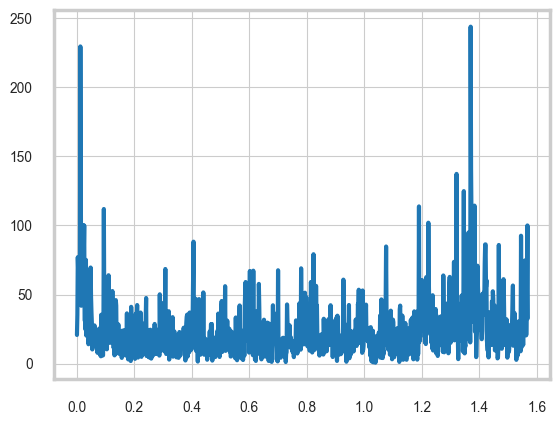

In [4]:
R = R[len(R)//2:]

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

print(np.abs(np.sin(theta) - np.sin(np.pi*(len(fft)-amax)/(2*len(fft)))), np.abs(np.sin(theta) - np.sin(np.pi*(amax)/(2*len(fft)))))
np.sin( [np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft))]), np.sin(theta)

In [5]:
np.pi/6, np.pi/5, np.pi/4, np.pi/3, np.pi/2

(0.5235987755982988,
 0.6283185307179586,
 0.7853981633974483,
 1.0471975511965976,
 1.5707963267948966)

In [6]:
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*10
# Set the actual angle
N=6
thetas = np.array([((i+1)/(N+1))*np.pi/2 for i in range(N)]) #np.arcsin(a)

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=5)
thetas_est = np.zeros(len(thetas), dtype = float)
# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for i,theta in enumerate(thetas):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using the ESPIRIT algorithm
    theta_est, angle = espirit.estimate_theta_toeplitz(R)
    thetas_est[i] = np.abs(angle[0])
    

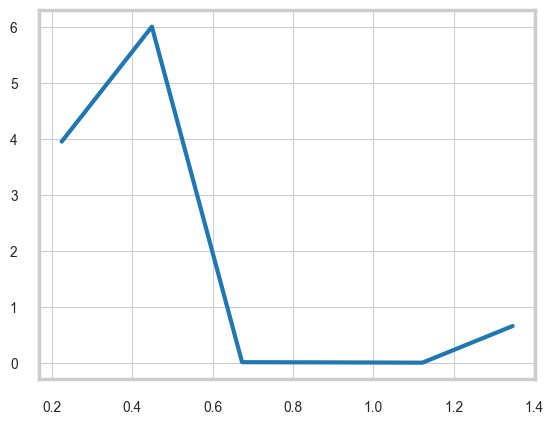

In [7]:
plt.plot(thetas, thetas_est/thetas)

In [8]:
factors = theta_est/thetas
factors

array([6.01260186, 3.00630093, 2.00420062, 1.50315046, 1.20252037,
       1.00210031])

In [9]:
factors_shifted = np.ones(len(factors))
factors_shifted = np.roll(factors, -1)
factors_shifted[-1] = 1
factors_shifted


array([3.00630093, 2.00420062, 1.50315046, 1.20252037, 1.00210031,
       1.        ])

In [10]:
factors/factors_shifted

array([2.        , 1.5       , 1.33333333, 1.25      , 1.2       ,
       1.00210031])

In [11]:
np.kron([1,2], [3,4])

array([3, 4, 6, 8])